# Project Guideline

- The project is to detect location of car plate and recognise it. The project is devided into 2 parts: detection and recognition

- Detection: YOLOV5
    - Goal 1: detect car plate bounding box (left top and right botton coordinate), achieve more than 99% maP@50 in test set
    - Goal 2: correct the orientation of cropped car plate bounding box
    - Goal 3: inference a image (1 frame of video) less than 20 ms

- Recognition:
    - Goal 1: Calibrate the car plate
    - Goal 2: transfer calibrated car plate to text


#Project FlowChart

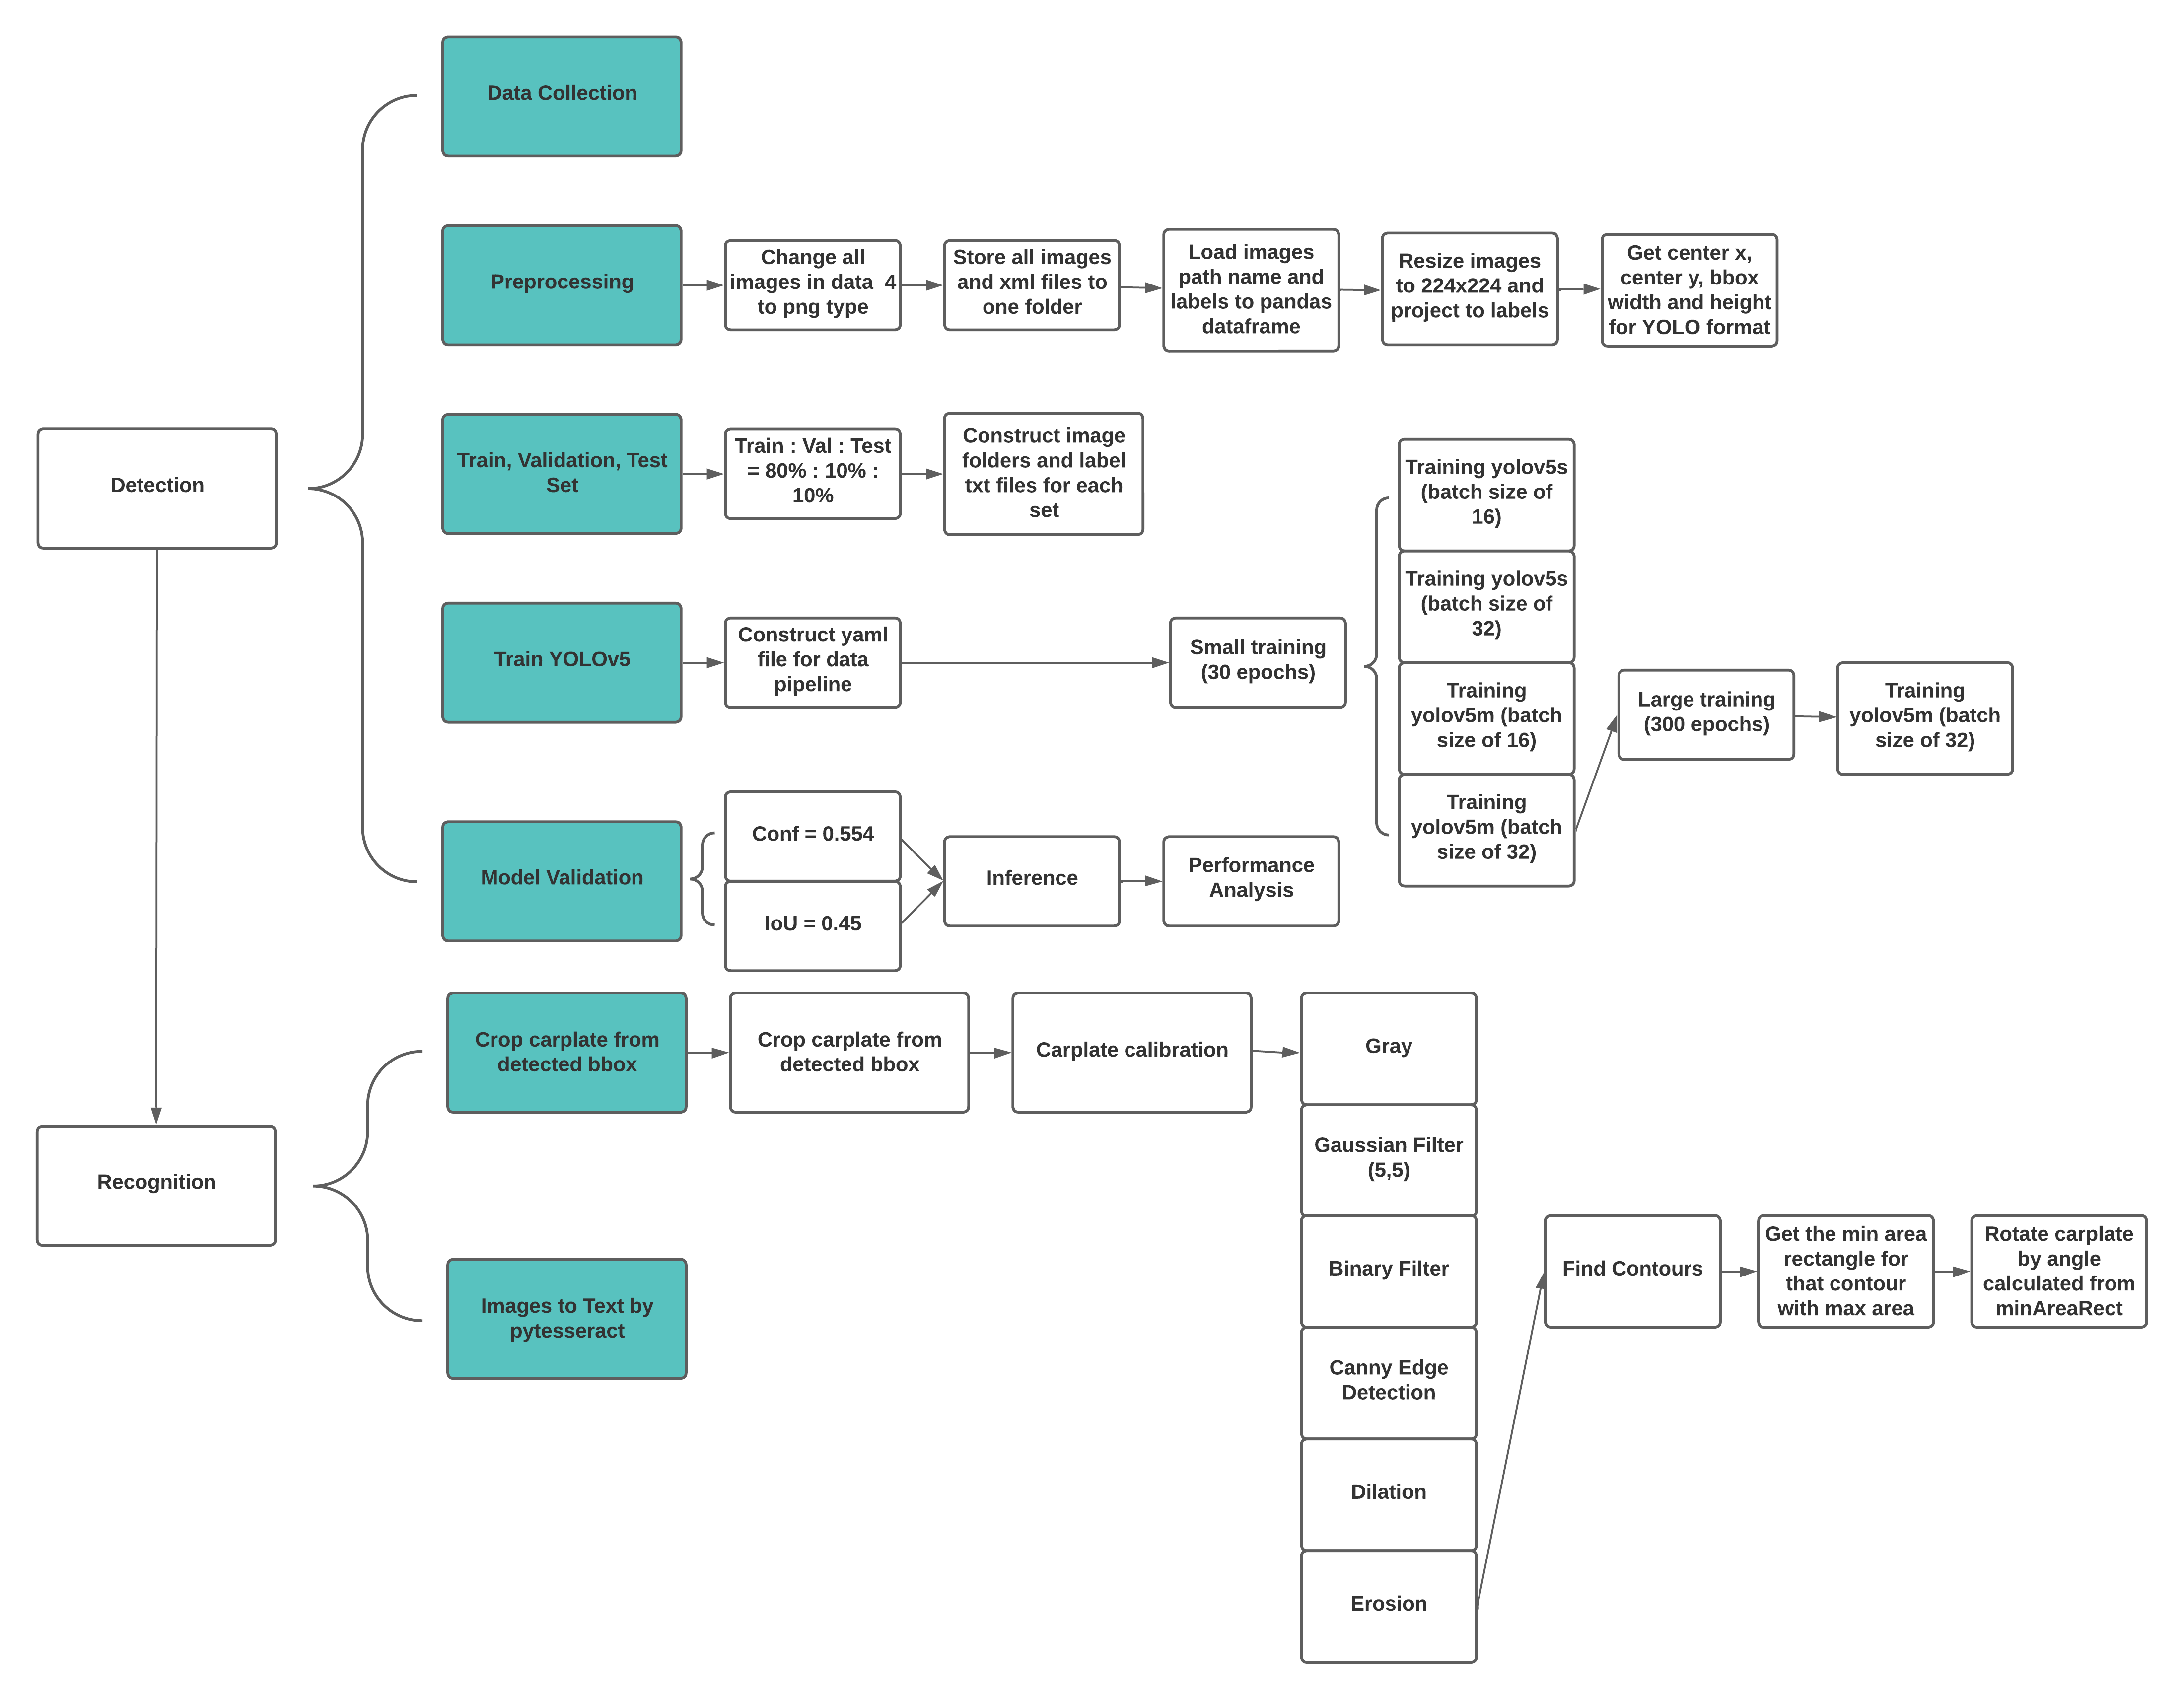

# Plate Detection

- Mount Google Drive

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
%cd /content/drive/My\ Drive/MIE1517/Project
!ls

Mounted at /content/drive
/content/drive/My Drive/MIE1517/Project
correct_result	final_data	      plate_detection_recognition.html	 wandb
cropped_result	img_to_crop	      plate_detection_recognition.ipynb  yolov5
data.yaml	plate_detection_data  video_data


- Import Packages

In [ ]:
# for monitoring training/val results (loss, maP, etc)
!pip install -q wandb --upgrade
import wandb
!wandb login # paste API after press ENTER

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 22.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 9.2 MB/s eta 0:00:00
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# for transform video to gif
!pip install imageio-ffmpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import yaml
from tqdm import tqdm
import shutil
import cv2
import torch
import torchvision
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from IPython.display import HTML
import imageio
import matplotlib.animation as animation
from skimage.transform import resize
from pandas.core.arrays import interval

import warnings
# Kill warning
warnings.simplefilter("ignore")

# os.environ["CUDA_ALLOC_CONF"] = "max_split_size_mb:8192"
print(os.path.abspath('.'))

%matplotlib inline

/content/drive/MyDrive/MIE1517/Project


In [ ]:
# check environment
print('torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

torch 1.13.1+cu116 _CudaDeviceProperties(name='NVIDIA A100-SXM4-40GB', major=8, minor=0, total_memory=40513MB, multi_processor_count=108)


## 0 File Structure:

- Project -> project root
    - correct_result -> rotated img from cropped_result
    - cropped_result -> cropped detected car plate from img_to_crop
    - img_to_crop -> new img for detection (not from train, val, test)
    - plate_detection_data -> all imgs for train, val, test file
        - data_1 -> 225 imgs from https://github.com/Asikpalysik/Automatic-License-Plate-Detection/tree/main/images
        - data_2 -> 433 imgs from https://www.kaggle.com/datasets/andrewmvd/car-plate-detection
        - data_3 -> 709 imgs from https://www.kaggle.com/datasets/achrafkhazri/labeled-licence-plates-dataset
        - data_4 -> 20000 imgs from CCPD (351977 in total) https://github.com/detectRecog/CCPD
        - final_data -> folder contain all files (imgs, xml) from data_1 to data_4
        - yolo_images -> train, val, test set
            - train
            - val
            - test
        - data_log_late_detec.txt -> log for data_1 to data_4
        - df.csv -> dataframe contains all imgs path and labels
    - video_data
    - wandb
    - yolov5 -> yolov5 main file
        - runs -> running file
            - detect -> detection results and log
            - train -> training results and log
                - running_32_medium_300
                - ...
            - val -> validation results and log
        - detect.py
        - train.py
        - val.py
        - ...
    - data.yaml
    - plate_detection_recognition.ipynb

## 1 Preprocessing

### 1.1 Data collection and data_4 xml constructions

data_1: https://github.com/Asikpalysik/Automatic-License-Plate-Detection/tree/main/images
  - imgs + xmls
  - 225 imgs

data_2: https://www.kaggle.com/datasets/andrewmvd/car-plate-detection
  - imgs + xmls
  - 433 imgs

data_3: https://www.kaggle.com/datasets/achrafkhazri/labeled-licence-plates-dataset
  - imgs + xmls
  - 709 imgs

data_4: https://github.com/detectRecog/CCPD
  - imgs + labels by imgs name
  - 300k+ imgs (only selected 20000 imgs, 2500 imgs from each folder: base, blur, challenge, db, fn, rotate, tilt, weather) 

Since data_4 has no xml file originally, the imgs name contains bbox labels, so we construct xml file for each imgs in data_4 as data_1, data_2 and data_3.

eg."025-95_113-154&383_386&473-386&473_177&454_154&383_363&402-0_0_22_27_27_33_16-37-15.jpg". ( 7 infos, separated by '-' )

"Area-Tilt degree-Bounding box coordinates-Four vertices locations-License plate number-Brightness-Blurriness"

so bbox of above sample: 154, 383, 386, 473 -> xmin, ymin, xmax, ymax

In [ ]:
plate_detection_data_path = 'plate_detection_data' # root path
data_4 = 'data_4'

In [ ]:
# construct xml label file for data_4 by extracting img name
for roots, dirs, files in os.walk(plate_detection_data_path+'/'+data_4): # walk through level by level
    if len(dirs) == 0:
        for file in files:
            if file.split('.')[-1] == 'jpg':
                # bbox extracted from img name
                x_min = int(file.split('-')[2].split('_')[0].split('&')[0])
                y_min = int(file.split('-')[2].split('_')[0].split('&')[1])
                x_max = int(file.split('-')[2].split('_')[1].split('&')[0])
                y_max = int(file.split('-')[2].split('_')[1].split('&')[1])

                # construct xml as data123's form
                tree = ET.ElementTree()
                annotation = ET.Element('annotation')
                folder = ET.Element('folder')
                folder.text = 'none'
                annotation.append(folder)

                filename = ET.Element('filename')
                filename.text = file
                annotation.append(filename)

                size = ET.Element('size')
                width = ET.SubElement(size, 'width')
                width.text = '720'
                height = ET.SubElement(size, 'height')
                height.text = '1160'
                depth = ET.SubElement(size, 'depth')
                depth.text = '3'
                annotation.append(size)

                object = ET.Element('object')
                bndbox = ET.SubElement(object, 'bndbox')
                xmin = ET.SubElement(bndbox, 'xmin')
                xmin.text = str(x_min)
                ymin = ET.SubElement(bndbox, 'ymin')
                ymin.text = str(y_min)
                xmax = ET.SubElement(bndbox, 'xmax')
                xmax.text = str(x_max)
                ymax = ET.SubElement(bndbox, 'ymax')
                ymax.text = str(y_max)
                annotation.append(object)

                tree._setroot(annotation)
                tree.write(plate_detection_data_path+'/'+data_4+'/'+file.split('.')[0]+'.xml')

### 1.2 Copy images and xmls from data_1, data_2, data_3 and data_4 to final_data (Project/final_data)

In [ ]:
destinated_path = 'final_data' # folder contains all imgs
yolo_image_path = 'plate_detection_data/yolo_images' # folder contains train, val, test imgs and labels for yolo

In [ ]:
if os.path.exists(destinated_path): # Project/final_data
    shutil.rmtree(destinated_path) # remove folder (also content inside) if exist
os.makedirs(destinated_path) # recreate data folder

if os.path.exists(plate_detection_data_path+'/'+destinated_path): # Project/plate_detection_data/final_data
    shutil.rmtree(plate_detection_data_path+'/'+destinated_path) # remove folder (also content inside) if exist

if os.path.exists(yolo_image_path): # Project/plate_detection_data/yolo_images
    shutil.rmtree(yolo_image_path) # remove folder (also content inside) if exist

count = 0
for roots, dirs, files in os.walk(plate_detection_data_path): # walk through level by level
    if len(dirs) == 0:
        for file in files:
            if file.split('.')[-1] == 'jpeg' or file.split('.')[-1] == 'jpg' or file.split('.')[-1] == 'png' or file.split('.')[-1] == 'xml':
                count += 1
                shutil.copy(roots+'/'+file, destinated_path+'/'+file)
                
print(count)

42734


### 1.2 Rename jpeg, jpg to png in Project/final_data

In [ ]:
for roots, dirs, files in os.walk(destinated_path): # walk through level by level
    if len(dirs) == 0:
        for file in files:
            if file.split('.')[-1] == 'jpeg' or file.split('.')[-1] == 'jpg':
                os.rename(roots+'/'+file, destinated_path+'/'+file.split('.')[0]+'.png')

### 1.3 Copy Project/final_data to plate_detection_data/final_data

- since 1.2 will loop all imgs in plate_detection_data, so final_data need to be under Project/final_data first. then copy it to plate_detection_data/final_data

In [ ]:
src = destinated_path
dst = plate_detection_data_path + '/' + destinated_path
if os.path.exists(dst): # remove folder (also content inside) if exist
    shutil.rmtree(dst)
os.makedirs(dst) # recreate data folder

count = 0
for root, subdirs, files in os.walk(src):
    for file in files:
        count += 1
        path = os.path.join(root, file)
        
        # If there is no duplicate file present, then move else don't move
        if not os.path.exists(os.path.join(dst, file)):  
            #shutil.move(path, os.path.join(dst, os.path.relpath(path, src)))
            shutil.copy(path, os.path.join(dst, file) )
        else:
            print("File not copied because duplicate file found at: "+path+"\n")
print(count)
# shutil.rmtree(destinated_path)

42734


### 1.4 Load images path name and labels from xml files to pandas dataframe

In [ ]:
plate_detection_data_path = 'plate_detection_data/final_data'

In [ ]:
images_info = dict(filepath=[], width=[], height=[], xmin=[], ymin=[], xmax=[], ymax=[])
count = 0

# load xml to dataframe
for roots, dirs, files in os.walk(plate_detection_data_path): # walk through level by level
    if len(dirs) == 0:
        for file in files:
            if file[-4:].lower() == '.{}'.format('xml'):
                count += 1
                xml_file = ET.parse(str(roots) + '/' + str(file))

                root = xml_file.getroot()
                # Access information in the file
                folder = root.find("folder").text
                filename = root.find("filename").text
                filename = filename.split('.')[0]

                width = int(root.find("size/width").text)
                height = int(root.find("size/height").text)
                depth = int(root.find("size/depth").text)

                # Access information in the object
                obj = root.find("object")
                xmin = int(obj.find("bndbox/xmin").text)
                ymin = int(obj.find("bndbox/ymin").text)
                xmax = int(obj.find("bndbox/xmax").text)
                ymax = int(obj.find("bndbox/ymax").text)

                images_info['filepath'].append(str(roots) + '/' + filename)
                images_info['width'].append(width)
                images_info['height'].append(height)
                images_info['xmin'].append(xmin)
                images_info['ymin'].append(ymin)
                images_info['xmax'].append(xmax)
                images_info['ymax'].append(ymax)
                
print(count)
df = pd.DataFrame(images_info)
df

21367


filepath  width  height  xmin  \
0                   plate_detection_data/final_data/N167    960     720   345   
1                   plate_detection_data/final_data/N114    250     166    15   
2                    plate_detection_data/final_data/N43    602     370   142   
3                   plate_detection_data/final_data/N113    400     300    39   
4                   plate_detection_data/final_data/N133   2432    1368   795   
...                                                  ...    ...     ...   ...   
21362  plate_detection_data/final_data/011875-91_90-3...    720    1160   362   
21363  plate_detection_data/final_data/014375-91_79-2...    720    1160   250   
21364  plate_detection_data/final_data/029375-93_87-2...    720    1160   273   
21365  plate_detection_data/final_data/031875-90_88-8...    720    1160    82   
21366  plate_detection_data/final_data/0125-90_94-248...    720    1160   248   

       ymin  xmax  ymax  
0       242   848   416  
1        33   200   126  
2       281   298   327  
3       129   108   157  
4       751  1095   840  
...     ...   ...   ...  
21362   524   545   587  
21363   478   475   553  
21364   504   570   608  
21365   470   419   582  
21366   528   449   604  

[21367 rows x 7 columns]

### 1.5 Resize images to 224*224 and modifiy corresponding labels

In [ ]:
for i in range(len(df)):
    # resize img
    own_img = cv2.imread(df.filepath[i]+'.png')
    resized_img = cv2.resize(own_img, (224, 224), fx=0, fy=0, interpolation=cv2.INTER_CUBIC)
    
    cv2.imwrite(df.filepath[i]+'.png', resized_img)

    # relocate bounding box
    df.xmin[i] = df.xmin[i] * 224/df.width[i]
    df.xmax[i] = df.xmax[i] * 224/df.width[i]
    df.ymin[i] = df.ymin[i] * 224/df.height[i]
    df.ymax[i] = df.ymax[i] * 224/df.height[i]
    df.width[i] = 224
    df.height[i] = 224

df

filepath  width  height  xmin  \
0                   plate_detection_data/final_data/N167    224     224    80   
1                   plate_detection_data/final_data/N114    224     224    13   
2                    plate_detection_data/final_data/N43    224     224    52   
3                   plate_detection_data/final_data/N113    224     224    21   
4                   plate_detection_data/final_data/N133    224     224    73   
...                                                  ...    ...     ...   ...   
21362  plate_detection_data/final_data/011875-91_90-3...    224     224   112   
21363  plate_detection_data/final_data/014375-91_79-2...    224     224    77   
21364  plate_detection_data/final_data/029375-93_87-2...    224     224    84   
21365  plate_detection_data/final_data/031875-90_88-8...    224     224    25   
21366  plate_detection_data/final_data/0125-90_94-248...    224     224    77   

       ymin  xmax  ymax  
0        75   197   129  
1        44   179   170  
2       170   110   197  
3        96    60   117  
4       122   100   137  
...     ...   ...   ...  
21362   101   169   113  
21363    92   147   106  
21364    97   177   117  
21365    90   130   112  
21366   101   139   116  

[21367 rows x 7 columns]

- Write df to csv for rerun

In [ ]:
df.to_csv('plate_detection_data/df.csv', index=False)

- Read csv to df

In [ ]:
df = pd.read_csv('plate_detection_data/df.csv')
df

filepath  width  height  xmin  \
0                   plate_detection_data/final_data/N167    224     224    80   
1                   plate_detection_data/final_data/N114    224     224    13   
2                    plate_detection_data/final_data/N43    224     224    52   
3                   plate_detection_data/final_data/N113    224     224    21   
4                   plate_detection_data/final_data/N133    224     224    73   
...                                                  ...    ...     ...   ...   
21362  plate_detection_data/final_data/011875-91_90-3...    224     224   112   
21363  plate_detection_data/final_data/014375-91_79-2...    224     224    77   
21364  plate_detection_data/final_data/029375-93_87-2...    224     224    84   
21365  plate_detection_data/final_data/031875-90_88-8...    224     224    25   
21366  plate_detection_data/final_data/0125-90_94-248...    224     224    77   

       ymin  xmax  ymax  
0        75   197   129  
1        44   179   170  
2       170   110   197  
3        96    60   117  
4       122   100   137  
...     ...   ...   ...  
21362   101   169   113  
21363    92   147   106  
21364    97   177   117  
21365    90   130   112  
21366   101   139   116  

[21367 rows x 7 columns]

### 1.6 Get center_x, center_y, bb_width and bb_height for YOLO format

In [ ]:
df['center_x'] = (df['xmax'] + df['xmin'])/(2*df['width'])
df['center_y'] = (df['ymax'] + df['ymin'])/(2*df['height'])

df['bb_width'] = (df['xmax'] - df['xmin'])/df['width']
df['bb_height'] = (df['ymax'] - df['ymin'])/df['height']

df

filepath  width  height  xmin  \
0                   plate_detection_data/final_data/N167    224     224    80   
1                   plate_detection_data/final_data/N114    224     224    13   
2                    plate_detection_data/final_data/N43    224     224    52   
3                   plate_detection_data/final_data/N113    224     224    21   
4                   plate_detection_data/final_data/N133    224     224    73   
...                                                  ...    ...     ...   ...   
21362  plate_detection_data/final_data/011875-91_90-3...    224     224   112   
21363  plate_detection_data/final_data/014375-91_79-2...    224     224    77   
21364  plate_detection_data/final_data/029375-93_87-2...    224     224    84   
21365  plate_detection_data/final_data/031875-90_88-8...    224     224    25   
21366  plate_detection_data/final_data/0125-90_94-248...    224     224    77   

       ymin  ...  ymax  center_x  center_y  bb_width  bb_height  
0        75  ...   129  0.618304  0.455357  0.522321   0.241071  
1        44  ...   170  0.428571  0.477679  0.741071   0.562500  
2       170  ...   197  0.361607  0.819196  0.258929   0.120536  
3        96  ...   117  0.180804  0.475446  0.174107   0.093750  
4       122  ...   137  0.386161  0.578125  0.120536   0.066964  
...     ...  ...   ...       ...       ...       ...        ...  
21362   101  ...   113  0.627232  0.477679  0.254464   0.053571  
21363    92  ...   106  0.500000  0.441964  0.312500   0.062500  
21364    97  ...   117  0.582589  0.477679  0.415179   0.089286  
21365    90  ...   112  0.345982  0.450893  0.468750   0.098214  
21366   101  ...   116  0.482143  0.484375  0.276786   0.066964  

[21367 rows x 11 columns]

### 1.7 Visualise random images in df

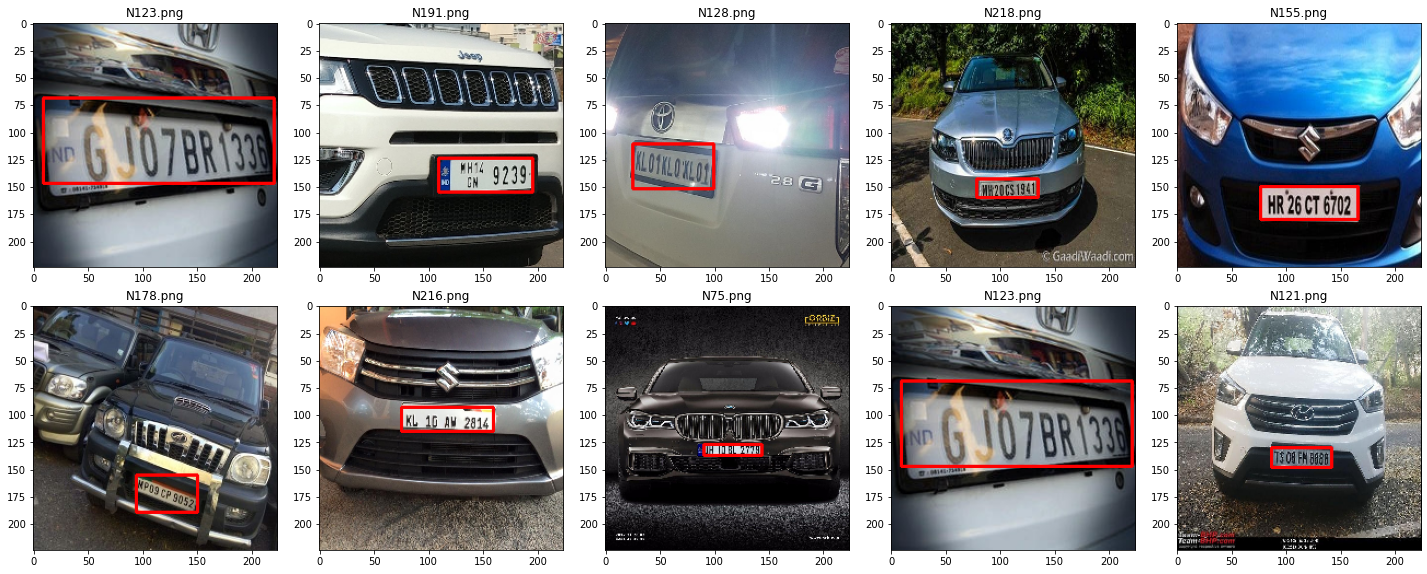

In [ ]:
# plot
np.random.seed(0) # keep same random result
plt.figure(figsize=(20, 8))
gs = gridspec.GridSpec(2, 5)
for k in range(len(df[:10])):
    i = k + np.random.randint(100, )
    ax = plt.subplot(gs[k])
    own_image_path = df.filepath[i]+'.png' # image name, dont need to concat path with img name since current path is img folder
    own_img = cv2.imread(own_image_path) # read img
    plot_own_img = cv2.cvtColor(own_img, cv2.COLOR_BGR2RGB)  # cv2 read image as BGR so need to transfer it to RGB if using plt.imshow()
    cv2.rectangle(plot_own_img, (int(df.xmin[i]), int(df.ymin[i])), (int(df.xmax[i]), int(df.ymax[i])), (255, 0, 0), 2) # ground truth bounding box
    ax.set_title(own_image_path.split('/')[-1])
    ax.grid(False)
    ax.imshow(plot_own_img)
plt.tight_layout()
plt.show()

## 2 Train, Validation, Test set

### 2.1 Split dataset (train: 0.8, val: 0.1, test: 0.1)

In [ ]:
# Keeping important columns only 
yolo_df = df[['filepath', 'center_x', 'center_y', 'bb_width', 'bb_height']]
# Performing 80-10-10 split
test_size = int(0.1 * len(df))

df_train, df_test = train_test_split(yolo_df, test_size=test_size, random_state=1)
df_train, df_val = train_test_split(df_train, test_size=test_size, random_state=1)

In [ ]:
df_train

filepath  center_x  center_y  \
3803   plate_detection_data/final_data/0171-16_15-287...  0.486607  0.357143   
5765   plate_detection_data/final_data/0221-19_26-189...  0.366071  0.482143   
10645  plate_detection_data/final_data/0875-5_3-146&4...  0.508929  0.450893   
13122  plate_detection_data/final_data/0207-0_1-305&4...  0.573661  0.439732   
737                  plate_detection_data/final_data/299  0.658482  0.750000   
...                                                  ...       ...       ...   
8141   plate_detection_data/final_data/0308-21_16-140...  0.312500  0.421875   
11732  plate_detection_data/final_data/0224-0_2-270&5...  0.531250  0.468750   
12813  plate_detection_data/final_data/0189-5_0-232&5...  0.441964  0.517857   
10271  plate_detection_data/final_data/0067-0_0-285&5...  0.482143  0.466518   
8876   plate_detection_data/final_data/0255-26_5-336&...  0.573661  0.459821   

       bb_width  bb_height  
3803   0.178571   0.098214  
5765   0.214286   0.107143  
10645  0.616071   0.142857  
13122  0.308036   0.066964  
737    0.058036   0.169643  
...         ...        ...  
8141   0.241071   0.129464  
11732  0.312500   0.071429  
12813  0.241071   0.080357  
10271  0.178571   0.040179  
8876   0.218750   0.116071  

[17095 rows x 5 columns]

In [ ]:
df_val

filepath  center_x  center_y  \
1368   plate_detection_data/final_data/055-3_5-231&43...  0.560268  0.430804   
6533   plate_detection_data/final_data/0104-19_16-391...  0.609375  0.361607   
11352  plate_detection_data/final_data/0065-0_0-327&3...  0.537946  0.319196   
19840  plate_detection_data/final_data/0165625-90_85-...  0.401786  0.337054   
17209  plate_detection_data/final_data/0162-0_1-286&4...  0.535714  0.408482   
...                                                  ...       ...       ...   
2533   plate_detection_data/final_data/0048-0_1-324&4...  0.522321  0.372768   
17359  plate_detection_data/final_data/0026-2_0-322&5...  0.497768  0.459821   
10022  plate_detection_data/final_data/0079-11_9-207&...  0.354911  0.381696   
11375  plate_detection_data/final_data/0112-3_6-349&4...  0.589286  0.446429   
2492   plate_detection_data/final_data/0019-1_1-340&5...  0.513393  0.439732   

       bb_width  bb_height  
1368   0.486607   0.111607  
6533   0.138393   0.080357  
11352  0.174107   0.040179  
19840  0.401786   0.058036  
17209  0.285714   0.058036  
...         ...        ...  
2533   0.151786   0.031250  
17359  0.102679   0.026786  
10022  0.138393   0.058036  
11375  0.214286   0.053571  
2492   0.089286   0.022321  

[2136 rows x 5 columns]

In [ ]:
df_test

filepath  center_x  center_y  \
20556  plate_detection_data/final_data/014375-90_88-2...  0.553571  0.377232   
14734  plate_detection_data/final_data/0032-0_9-354&4...  0.544643  0.395089   
5507   plate_detection_data/final_data/0144-21_39-303...  0.511161  0.439732   
16685  plate_detection_data/final_data/0184-2_1-289&5...  0.535714  0.488839   
3672   plate_detection_data/final_data/0186-15_17-299...  0.520089  0.363839   
...                                                  ...       ...       ...   
3057   plate_detection_data/final_data/0022-0_1-360&4...  0.549107  0.417411   
17153  plate_detection_data/final_data/0207-0_0-250&4...  0.502232  0.457589   
8027   plate_detection_data/final_data/0306-22_13-252...  0.466518  0.372768   
7102   plate_detection_data/final_data/0303-17_11-319...  0.558036  0.515625   
15222  plate_detection_data/final_data/0045-1_5-297&5...  0.484375  0.444196   

       bb_width  bb_height  
20556  0.321429   0.066964  
14734  0.107143   0.031250  
5507   0.183036   0.075893  
16685  0.276786   0.066964  
3672   0.209821   0.084821  
...         ...        ...  
3057   0.098214   0.022321  
17153  0.316964   0.066964  
8027   0.236607   0.129464  
7102   0.232143   0.129464  
15222  0.147321   0.031250  

[2136 rows x 5 columns]

### 2.2 Construct folders plate_detection_data/yolo_images and allocate images for train, val, test set

In [ ]:
os.makedirs(yolo_image_path) # recreate data folder

In [ ]:
train_path = os.path.join(yolo_image_path, 'train')
val_path = os.path.join(yolo_image_path,'val')
test_path = os.path.join(yolo_image_path, 'test')

In [ ]:
if not os.path.exists(train_path):
    os.makedirs(train_path)
    print('Made folder for train set')

if not os.path.exists(val_path):
    os.makedirs(val_path)
    print('Made folder for val set')

if not os.path.exists(test_path):
    os.makedirs(test_path)
    print('Made folder for test set')
    
images_path = 'plate_detection_data/final_data' # 'plate_detection_data/final_data'

print('Moving images for train set')
for _, row  in tqdm(df_train.iterrows()):
    annotation_path = row['filepath']
    image_name = os.path.split(annotation_path)[-1].replace('.xml','')
    image_src = os.path.join(images_path, f'{image_name}.png')
    image_dst = os.path.join(train_path, f'{image_name}.png')
    shutil.copy2(image_src, image_dst)
    label_text = f"0 {row['center_x']} {row['center_y']} {row['bb_width']} {row['bb_height']}"
    with open(os.path.join(train_path, f'{image_name}.txt'), 'w') as f:
        f.write(label_text)
print('Done moving images for train set')

print('Moving images for val set')
for _, row  in tqdm(df_val.iterrows()):
    annotation_path = row['filepath']
    image_name = os.path.split(annotation_path)[-1].replace('.xml','')
    image_src = os.path.join(images_path, f'{image_name}.png')
    image_dst = os.path.join(val_path, f'{image_name}.png')
    shutil.copy2(image_src, image_dst)
    label_text = f"0 {row['center_x']} {row['center_y']} {row['bb_width']} {row['bb_height']}"
    with open(os.path.join(val_path, f'{image_name}.txt'), 'w') as f:
        f.write(label_text)
print('Done moving images for val set')

print('Moving images for test set')
for _, row  in tqdm(df_test.iterrows()):
    annotation_path = row['filepath']
    image_name = os.path.split(annotation_path)[-1].replace('.xml','')
    image_src = os.path.join(images_path, f'{image_name}.png')
    image_dst = os.path.join(test_path, f'{image_name}.png')
    shutil.copy2(image_src, image_dst)
    label_text = f"0 {row['center_x']} {row['center_y']} {row['bb_width']} {row['bb_height']}"
    with open(os.path.join(test_path, f'{image_name}.txt'), 'w') as f:
        f.write(label_text)
print('Done moving images for test set')

Made folder for train set
Made folder for val set
Made folder for test set
Moving images for train set


17095it [08:52, 32.08it/s]


Done moving images for train set
Moving images for val set


2136it [00:27, 77.40it/s]


Done moving images for val set
Moving images for test set


2136it [00:27, 77.33it/s]

Done moving images for test set


## 3 Training YOLOv5 Model

### 3.1 Clone YOLO

In [ ]:
! git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 15300, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 15300 (delta 4), reused 2 (delta 0), pack-reused 15287
Receiving objects: 100% (15300/15300), 14.14 MiB | 20.36 MiB/s, done.
Resolving deltas: 100% (10494/10494), done.


- YOLO Architectures

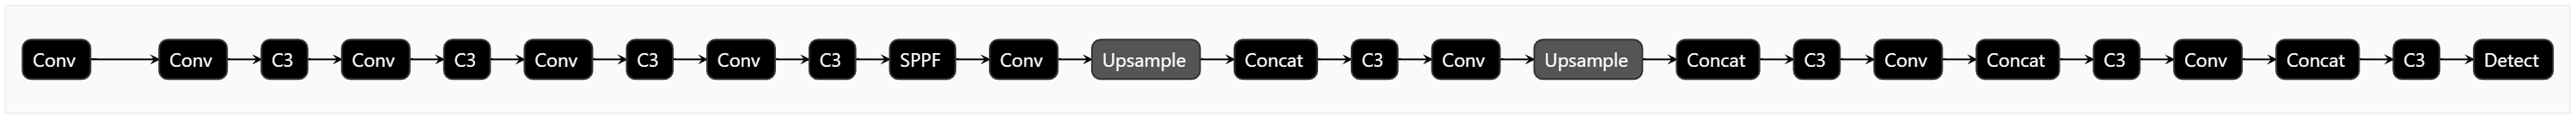

### 3.2 Setup environment by requirement.txt

In [ ]:
! pip install -r yolov5/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.9 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.
cvxpy 1.2.3 requires setuptools<=64.0.2, but you have setuptools 67.6.0 which is incompatible.


### 3.3 Construct yaml file for training YOLO

In [ ]:
# creating data.yaml file for training yolov5
data = {
    'names':['License Plate'],
    'nc':1,
    'train':os.path.abspath(train_path),
    'val':os.path.abspath(val_path),
    'test':os.path.abspath(test_path)
}

with open('data.yaml', 'w') as f:
    yaml.dump(data, f)

### 3.4 Train model with different types of yolov5 (only 2: small, medium), then select a best type for final training

- all running results: https://wandb.ai/weijun_huang/train

In [ ]:
def train_yolo(BATCH_SIZE, YOLO_WEIGHT, EPOCHS):
    if YOLO_WEIGHT == 'yolov5/yolov5s.pt':
        yolo_type = 'small'
        CONFIG = 'yolov5/models/yolov5s.yaml'
    elif YOLO_WEIGHT == 'yolov5/yolov5m.pt':
        yolo_type = 'medium'
        CONFIG = 'yolov5/models/yolov5m.yaml'
    # elif YOLO_WEIGHT == 'yolov5/yolov5l.pt':
    #     yolo_type = 'large'
    #     CONFIG = 'yolov5/models/yolov5l.yaml'
    # elif YOLO_WEIGHT == 'yolov5/yolov5x.pt':
    #     yolo_type = 'xlarge'
    #     CONFIG = 'yolov5/models/yolov5x.yaml'
    NAME = 'running_{}_{}_{}'.format(BATCH_SIZE, yolo_type, EPOCHS)

    !python yolov5/train.py \
    --img 224 \
    --cfg {CONFIG} \
    --batch-size {BATCH_SIZE} \
    --epochs {EPOCHS} \
    --data data.yaml \
    --weights {YOLO_WEIGHT} \
    --name {NAME}

    return yolo_type

In [ ]:
def visual_result(BATCH_SIZE, yolo_type, EPOCHS):
    NAME = 'running_{}_{}_{}'.format(BATCH_SIZE, yolo_type, EPOCHS)
    results = plt.imread('yolov5/runs/train/' + NAME + '/results.png')
    plt.figure(figsize=(20,15))
    plt.axis('off')
    plt.imshow(results)
    plt.show()

- Train with batch_size 16 and 32, yolov5s

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: Currently logged in as: huangweijun135 (weijun_huang). Use `wandb login --relogin` to force relogin
train: weights=yolov5/yolov5s.pt, cfg=yolov5/models/yolov5s.yaml, data=data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=30, batch_size=16, imgsz=224, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=running_16_small_30, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-119-g5

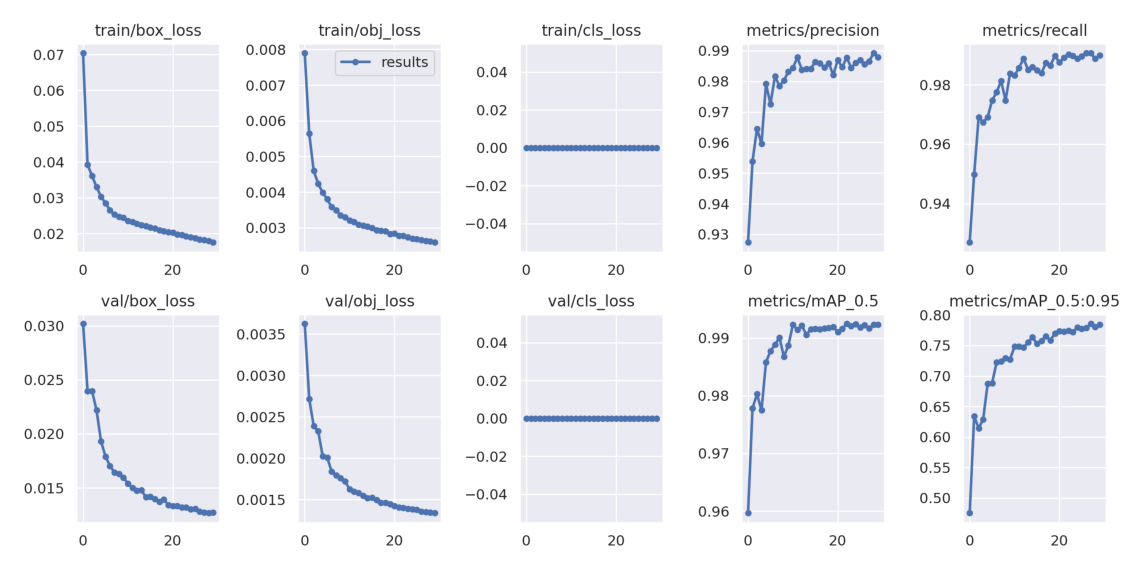

In [ ]:
BATCH_SIZE = 16
EPOCHS = 30
YOLO_WEIGHT = 'yolov5/yolov5s.pt' # yolo small
yolo_type = train_yolo(BATCH_SIZE, YOLO_WEIGHT, EPOCHS)
visual_result(BATCH_SIZE, yolo_type, EPOCHS)

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: Currently logged in as: huangweijun135 (weijun_huang). Use `wandb login --relogin` to force relogin
train: weights=yolov5/yolov5s.pt, cfg=yolov5/models/yolov5s.yaml, data=data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=30, batch_size=32, imgsz=224, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=running_32_small_30, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-119-g5

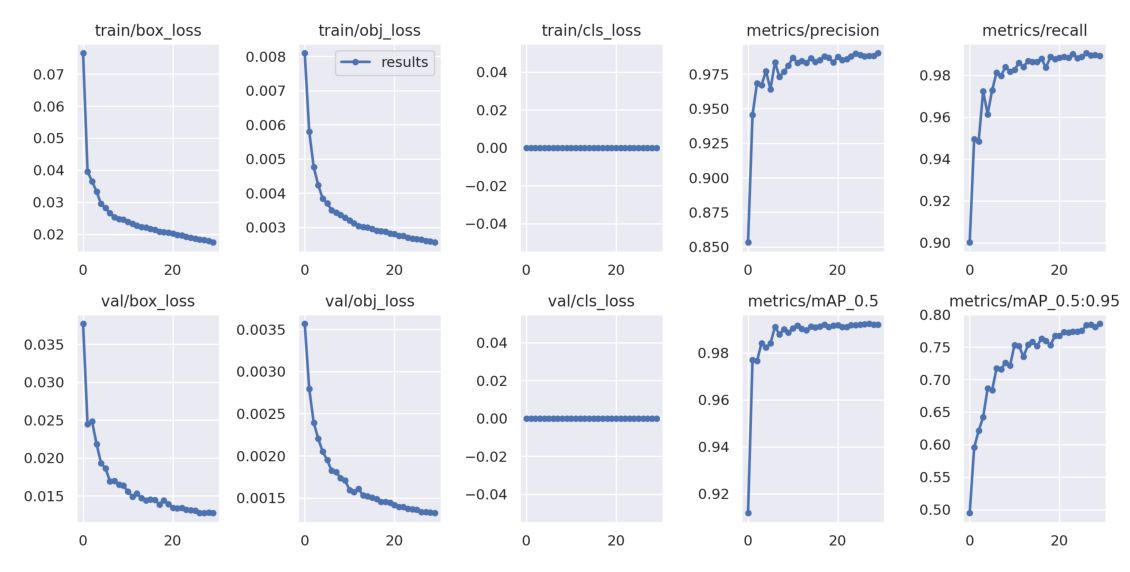

In [ ]:
BATCH_SIZE = 32
EPOCHS = 30
YOLO_WEIGHT = 'yolov5/yolov5s.pt' # yolo small
yolo_type = train_yolo(BATCH_SIZE, YOLO_WEIGHT, EPOCHS)
visual_result(BATCH_SIZE, yolo_type, EPOCHS)

- Train with batch_size 16 and 32, yolov5m

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: Currently logged in as: huangweijun135 (weijun_huang). Use `wandb login --relogin` to force relogin
train: weights=yolov5/yolov5m.pt, cfg=yolov5/models/yolov5m.yaml, data=data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=30, batch_size=16, imgsz=224, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=running_16_medium_30, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-119-g

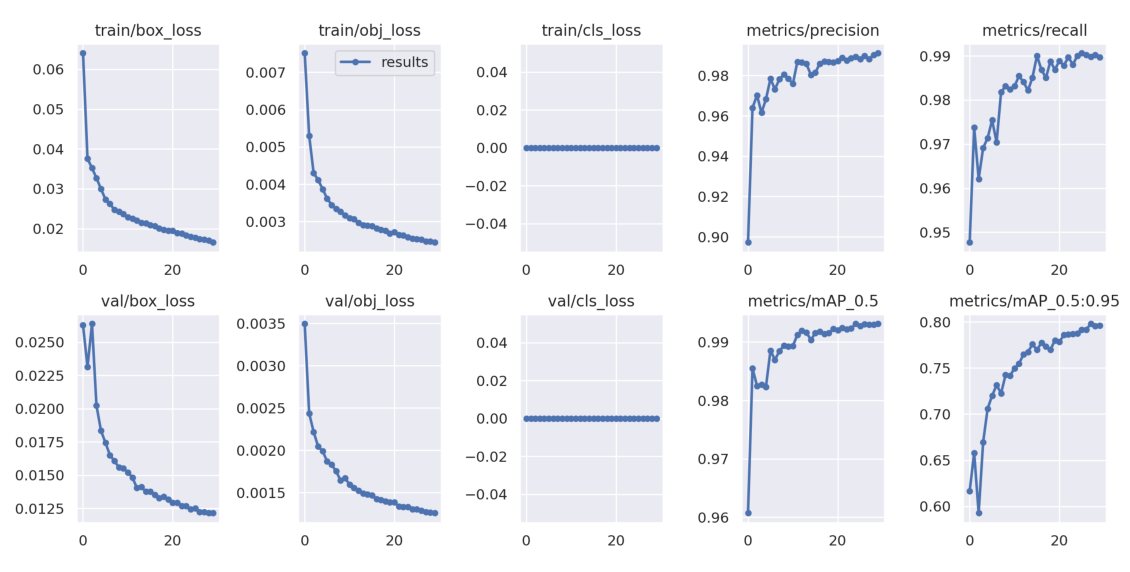

In [ ]:
BATCH_SIZE = 16
EPOCHS = 30
YOLO_WEIGHT = 'yolov5/yolov5m.pt' # yolo medium
yolo_type = train_yolo(BATCH_SIZE, YOLO_WEIGHT, EPOCHS)
visual_result(BATCH_SIZE, yolo_type, EPOCHS)

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: Currently logged in as: huangweijun135 (weijun_huang). Use `wandb login --relogin` to force relogin
train: weights=yolov5/yolov5m.pt, cfg=yolov5/models/yolov5m.yaml, data=data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=30, batch_size=32, imgsz=224, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=running_32_medium_30, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-119-g

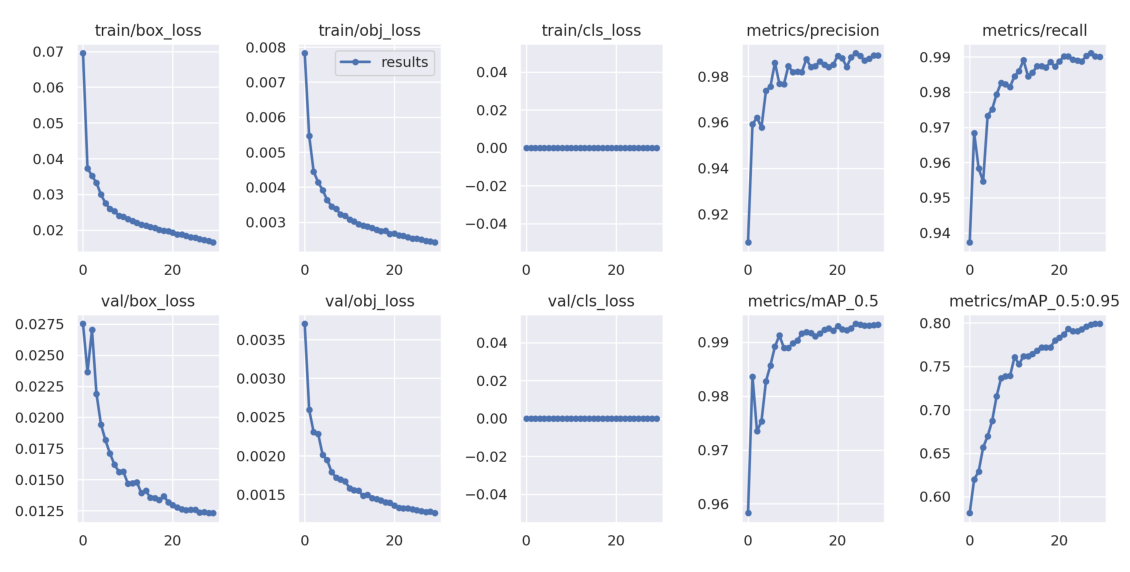

In [ ]:
BATCH_SIZE = 32
EPOCHS = 30
YOLO_WEIGHT = 'yolov5/yolov5m.pt' # yolo medium
yolo_type = train_yolo(BATCH_SIZE, YOLO_WEIGHT, EPOCHS)
visual_result(BATCH_SIZE, yolo_type, EPOCHS)

### 3.5 Train more epochs by using best hyperparameters

from https://wandb.ai/weijun_huang/train, best hyp: 32 batch size, yolov5 medium

- Train yolov5m (medium) with 300 epochs, weight using running_32_medium_30 best.pt

In [ ]:
BATCH_SIZE = 32
EPOCHS = 300
YOLO_WEIGHT = 'yolov5/runs/train/running_32_medium_30/weights/best.pt' # yolo medium, use the model just trained as a starting weight

!python yolov5/train.py \
--img 224 \
--cfg yolov5/models/yolov5m.yaml \
--batch-size {BATCH_SIZE} \
--epochs {EPOCHS} \
--data data.yaml \
--weights {YOLO_WEIGHT} \
--name running_32_medium_300

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: Currently logged in as: huangweijun135 (weijun_huang). Use `wandb login --relogin` to force relogin
train: weights=yolov5/runs/train/running_32_medium_30/weights/best.pt, cfg=yolov5/models/yolov5m.yaml, data=data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=300, batch_size=32, imgsz=224, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=running_32_medium_300, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/u

- Visualise 300-epoch training loss and results

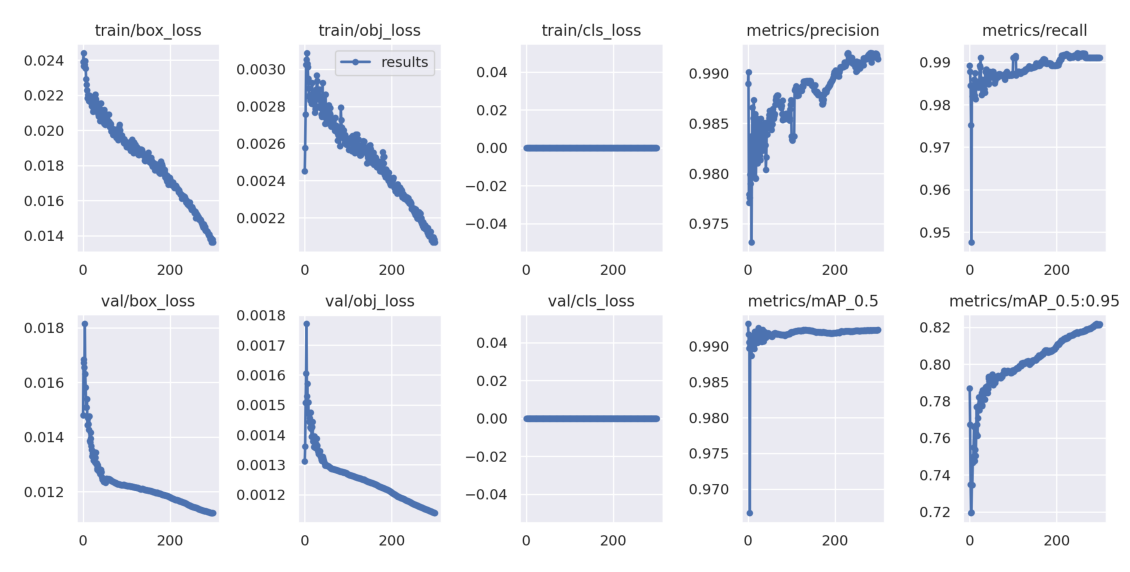

In [ ]:
results = plt.imread('yolov5/runs/train/running_32_medium_300/results.png')
plt.figure(figsize=(20,15))
plt.axis('off')
plt.imshow(results)
plt.show()

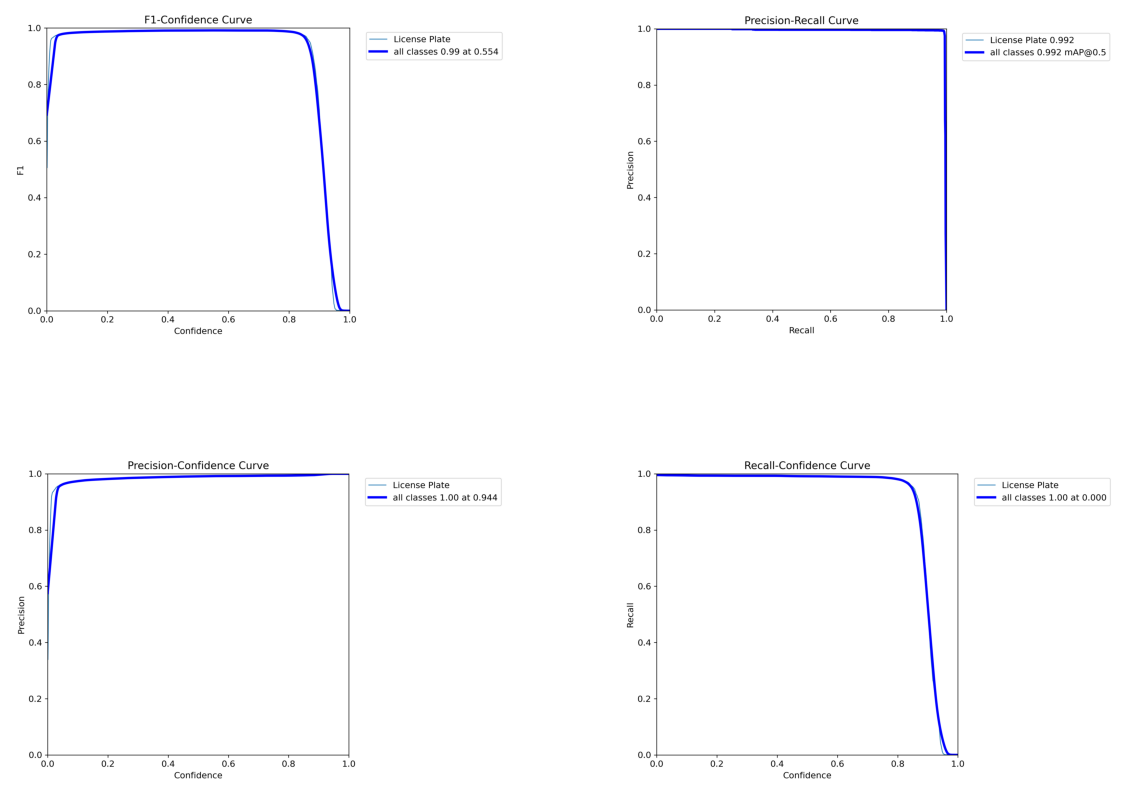

In [ ]:
plt.figure(figsize=(20,15))
f1 = plt.imread('yolov5/runs/train/running_32_medium_300/F1_curve.png')
plt.subplot(2,2,1)
plt.axis('off')
plt.imshow(f1)

pr = plt.imread('yolov5/runs/train/running_32_medium_300/PR_curve.png')
plt.subplot(2,2,2)
plt.axis('off')
plt.imshow(pr)

p = plt.imread('yolov5/runs/train/running_32_medium_300/P_curve.png')
plt.subplot(2,2,3)
plt.axis('off')
plt.imshow(p)

r = plt.imread('yolov5/runs/train/running_32_medium_300/R_curve.png')
plt.subplot(2,2,4)
plt.axis('off')
plt.imshow(r)

plt.show()

## 4 Model Validation

### 4.1 Load best model

In [ ]:
best_model_path = 'yolov5/runs/train/running_32_medium_300/weights/best.pt'
yolov5_model = torch.hub.load(repo_or_dir='yolov5', model='custom', path=best_model_path, source='local') # model='custom'

requirements: YOLOv5 requirements "gitpython>=3.1.30" "setuptools>=65.5.1" not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 9.1 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0

requirements: 2 packages updated per /content/drive/MyDrive/MIE1517/Project/yolov5/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 v7.0-119-g5543b89 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Fusing layers... 
YOLOv5m summary: 212 layers, 20852934 parameters, 0 gradients
Adding AutoShape..

### 4.2 model confidence and IOU threshold setting

In [ ]:
yolov5_model.conf = 0.554 # default 0.25, 0.554 come from f1 graph
yolov5_model.iou = 0.45 # default 0.45

In [ ]:
yolov5_model

AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 48, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(96, 48, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(96, 48, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1))
  

### 4.2 Inference model on test set

- Inference

In [ ]:
!python yolov5/val.py \
--weights yolov5/runs/train/running_32_medium_30/weights/best.pt \
--device 0 \
--conf 0.554 \
--iou-thres 0.45 \
--data data.yaml \
--task test --img 224 \
--half

val: data=data.yaml, weights=['yolov5/runs/train/running_32_medium_30/weights/best.pt'], batch_size=32, imgsz=224, conf_thres=0.554, iou_thres=0.45, max_det=300, task=test, device=0, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=exp, exist_ok=False, half=True, dnn=False
WARNING ⚠️ confidence threshold 0.554 > 0.001 produces invalid results
YOLOv5 🚀 v7.0-119-g5543b89 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Fusing layers... 
YOLOv5m summary: 212 layers, 20852934 parameters, 0 gradients
test: Scanning /content/drive/MyDrive/MIE1517/Project/plate_detection_data/yolo_images/test.cache... 2136 images, 0 backgrounds, 0 corrupt: 100% 2136/2136 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 67/67 [00:13<00:00,  4.98it/s]
                   all       2136       2136      0.989      0.992

- Plot results

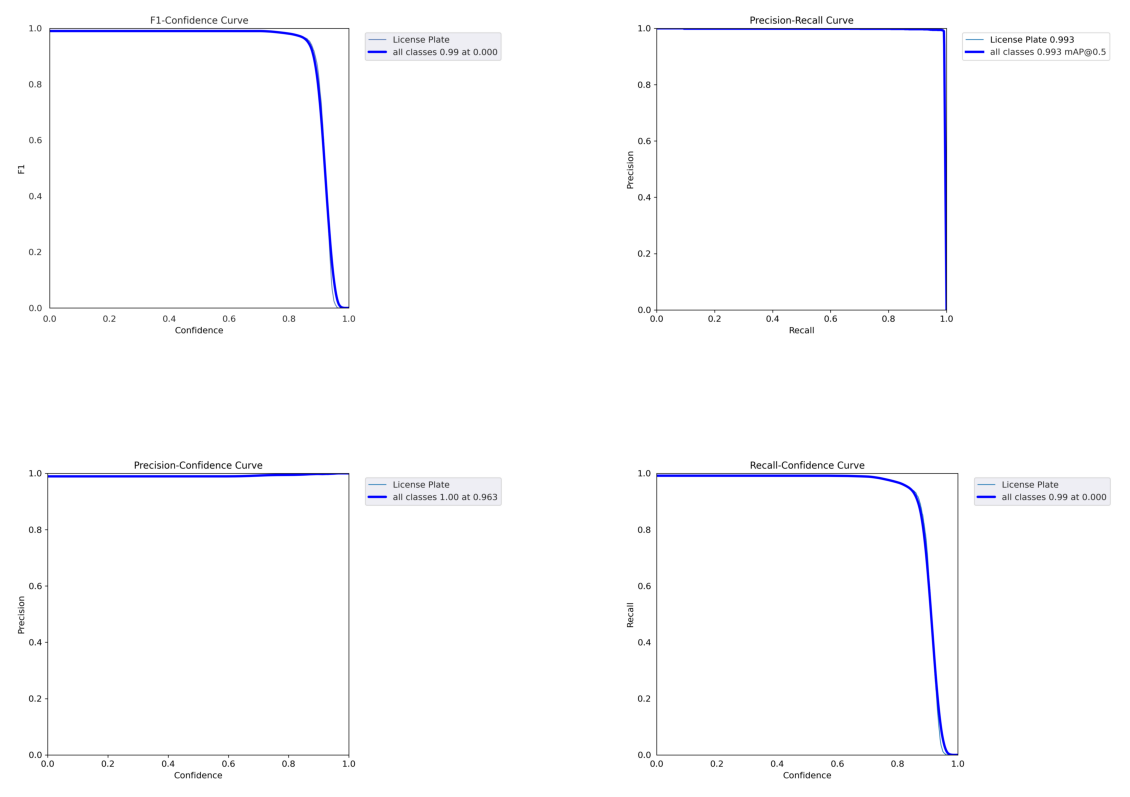

In [ ]:
plt.figure(figsize=(20,15))
f1 = plt.imread('yolov5/runs/val/exp/F1_curve.png')
plt.subplot(2,2,1)
plt.axis('off')
plt.imshow(f1)

pr = plt.imread('yolov5/runs/val/exp/PR_curve.png')
plt.subplot(2,2,2)
plt.axis('off')
plt.imshow(pr)

p = plt.imread('yolov5/runs/val/exp/P_curve.png')
plt.subplot(2,2,3)
plt.axis('off')
plt.imshow(p)

r = plt.imread('yolov5/runs/val/exp/R_curve.png')
plt.subplot(2,2,4)
plt.axis('off')
plt.imshow(r)

plt.show()

### 4.3 Inference model on a video

- Visualise original video

In [ ]:
# !ffmpeg -i video_data/car0.mp4 -vf "scale=160:-1,split[s0][s1];[s0]palettegen[p];[s1][p]paletteuse" -loop 0 video_data/car0.gif

![car0_ori](https://user-images.githubusercontent.com/54711980/224529832-a3f31f6a-8011-49b6-915d-d76d456a6d51.gif)

- Inference

In [ ]:
!python yolov5/detect.py \
--weights yolov5/runs/train/running_32_medium_300/weights/best.pt \
--source video_data/car0.mp4 \
--conf 0.554

detect: weights=['yolov5/runs/train/running_32_medium_300/weights/best.pt'], source=video_data/car0.mp4, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.554, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-119-g5543b89 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Fusing layers... 
YOLOv5m summary: 212 layers, 20852934 parameters, 0 gradients
video 1/1 (1/642) /content/drive/MyDrive/MIE1517/Project/video_data/car0.mp4: 384x640 1 License Plate, 21.0ms
video 1/1 (2/642) /content/drive/MyDrive/MIE1517/Project/video_data/car0.mp4: 384x640 1 License Plate, 14.6ms
video 1/1 (3/642) /content/drive/MyDrive/MIE1517/Project/video_data/car0.mp4: 384x6

- Visualise result

In [ ]:
# !ffmpeg -i yolov5/runs/detect/exp/car0.mp4 -vf "scale=160:-1,split[s0][s1];[s0]palettegen[p];[s1][p]paletteuse" -loop 0 yolov5/runs/detect/exp/car0.gif

![car0_result](https://user-images.githubusercontent.com/54711980/224529968-ee4ba25f-3e0a-4f88-9ecc-4aa6a3972b75.gif)

# Plate Recognition

## 5 Cropped plate correction

### 5.1 Get cropped car plate from new dataset

- Get new data (15 from rest of CCPD2019, randonly selected, and 3 from own car), store in Project/img_to_crop

In [ ]:
img_to_crop_path = 'img_to_crop'
img_to_crop_list = []
for roots, dirs, files in os.walk(img_to_crop_path): # walk through level by level
    if len(dirs) == 0:
        for file in files:
            # os.rename(roots+'/'+file, roots+'/'+file.split('.')[0]+'.png')
            img_to_crop_list.append(roots+'/'+file)

In [ ]:
crop_df = pd.DataFrame({'filepath':img_to_crop_list})
crop_df

filepath
0   img_to_crop/0082-2_3-299&521_429&574-428&568_2...
1   img_to_crop/0083-0_0-215&387_346&440-346&440_2...
2   img_to_crop/0066-20_18-291&494_368&566-367&566...
3   img_to_crop/025-25_12-305&431_450&575-450&515_...
4   img_to_crop/005-0_4-462&482_549&530-549&529_46...
5   img_to_crop/0076-1_10-269&568_400&617-393&614_...
6   img_to_crop/0230-10_6-368&544_557&646-552&646_...
7   img_to_crop/0231-0_4-237&507_495&582-495&582_2...
8   img_to_crop/0231-0_3-273&473_518&552-518&552_2...
9   img_to_crop/04-26_16-213&440_405&614-405&527_2...
10  img_to_crop/01-90_87-240&501_441&563-437&567_2...
11  img_to_crop/02-90_82-239&451_513&533-535&548_2...
12  img_to_crop/02-89_89-290&510_534&594-537&587_3...
13  img_to_crop/02-90_93-196&484_481&565-480&565_1...
14  img_to_crop/02-92_88-268&513_509&595-507&596_2...
15                          img_to_crop/CVLD516_1.png
16                          img_to_crop/CVLD516_2.png
17                             img_to_crop/M9659E.png

- Crop new imgs by model

no results: 0


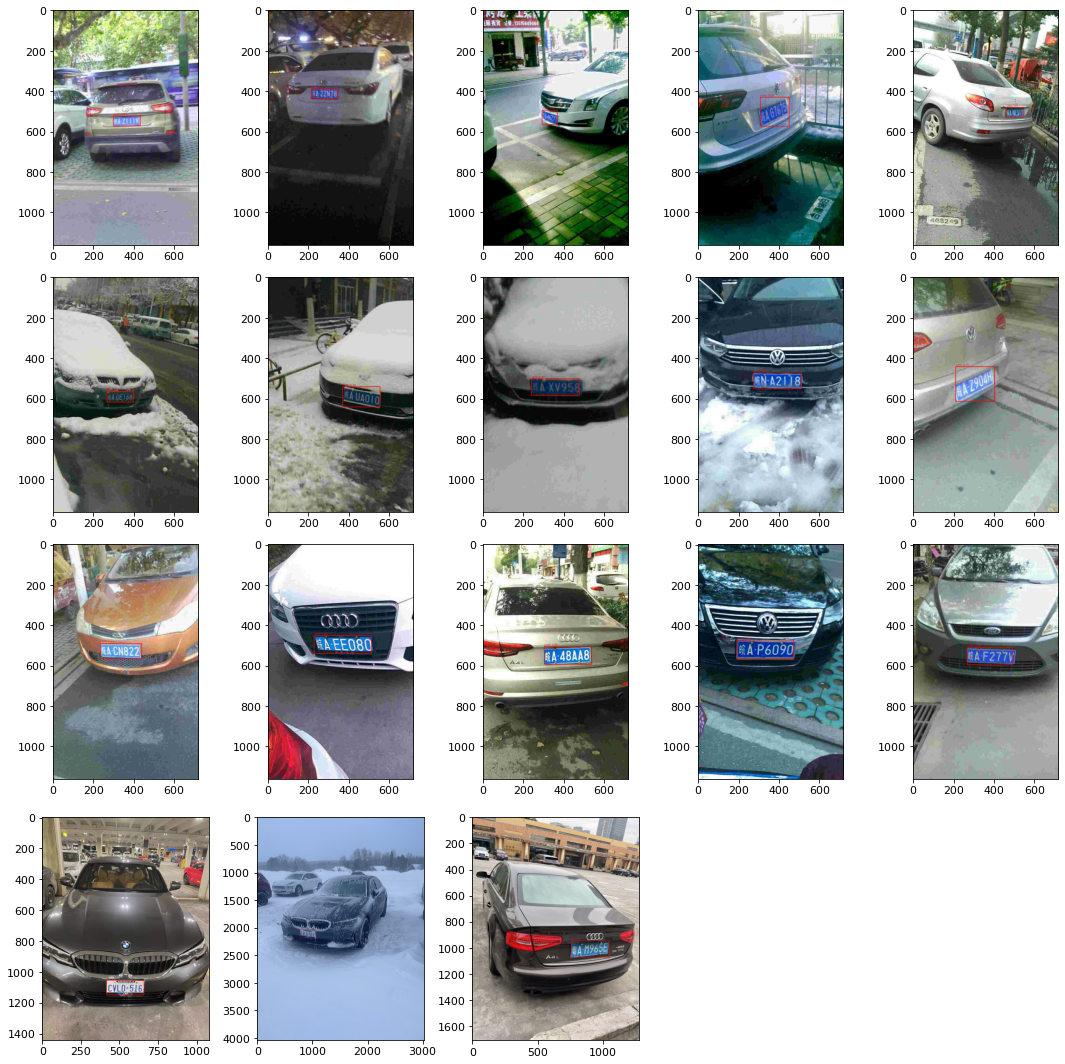

In [ ]:
count = 0
number_plate_list = []

plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(int(np.ceil(len(crop_df)/5)), 5)

for i, img_to_crop in enumerate(crop_df.filepath):
    ax = plt.subplot(gs[i])
    # print(test_img)
    ori_img = cv2.imread(img_to_crop)
    ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
    ori_img_cpy = ori_img.copy() # avoid get rect
    
    resized_img = cv2.resize(ori_img, (224, 224), fx=0, fy=0, interpolation=cv2.INTER_CUBIC)

    prediction = yolov5_model(resized_img)
    prediction_df = prediction.pandas().xyxy[0] # top 1

    if len(prediction_df) == 0:
        count+=1
        # ax.set_title('no_results_' + test_img.split('/')[-1])
        ax.set_title('no_results')
        cv2.putText(ori_img, 'no_results', (50, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    else:
        # ax.set_title(test_img.split('/')[-1])
        for i in range(len(prediction_df)):
            # resize results
            x_min = int(prediction_df.iloc[i]['xmin'])
            x_max = int(prediction_df.iloc[i]['xmax'])
            y_min = int(prediction_df.iloc[i]['ymin'])
            y_max = int(prediction_df.iloc[i]['ymax'])
            cv2.rectangle(resized_img, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2) # ground truth bounding box

            # original
            x_min_ori = int(prediction_df.iloc[i]['xmin'] * ori_img.shape[1]/224)
            x_max_ori = int(prediction_df.iloc[i]['xmax'] * ori_img.shape[1]/224)
            y_min_ori = int(prediction_df.iloc[i]['ymin'] * ori_img.shape[0]/224)
            y_max_ori = int(prediction_df.iloc[i]['ymax'] * ori_img.shape[0]/224)

            number_plate = ori_img_cpy[y_min_ori:y_max_ori, x_min_ori:x_max_ori]
            number_plate_list.append(number_plate)
            # print(x_min_ori, y_min_ori, x_max_ori, y_max_ori)
            cv2.rectangle(ori_img, (x_min_ori, y_min_ori), (x_max_ori, y_max_ori), (255, 0, 0), 2)
            cv2.putText(ori_img, 'conf: ' + str(round(prediction_df.iloc[i]['confidence'], 2)), (x_min_ori, y_min_ori-5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0))

    # plt.imsave(test_result_root+'/'+test_img.split('/')[-1], ori_img)

    ax.grid(False)
    ax.imshow(ori_img)
print('no results:', count)
plt.tight_layout()
plt.show()

### 5.2 Get the cropped bbox (original size) and decode img name to car plate, then set to img name

In [ ]:
cropped_result_root = 'cropped_result'
if os.path.exists(cropped_result_root): # remove folder (also content inside) if exist
    shutil.rmtree(cropped_result_root)
os.makedirs(cropped_result_root) # recreate data folder

In [ ]:
len(number_plate_list)

18

In [ ]:
alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
             'X', 'Y', 'Z', 'O']
ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
       'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']

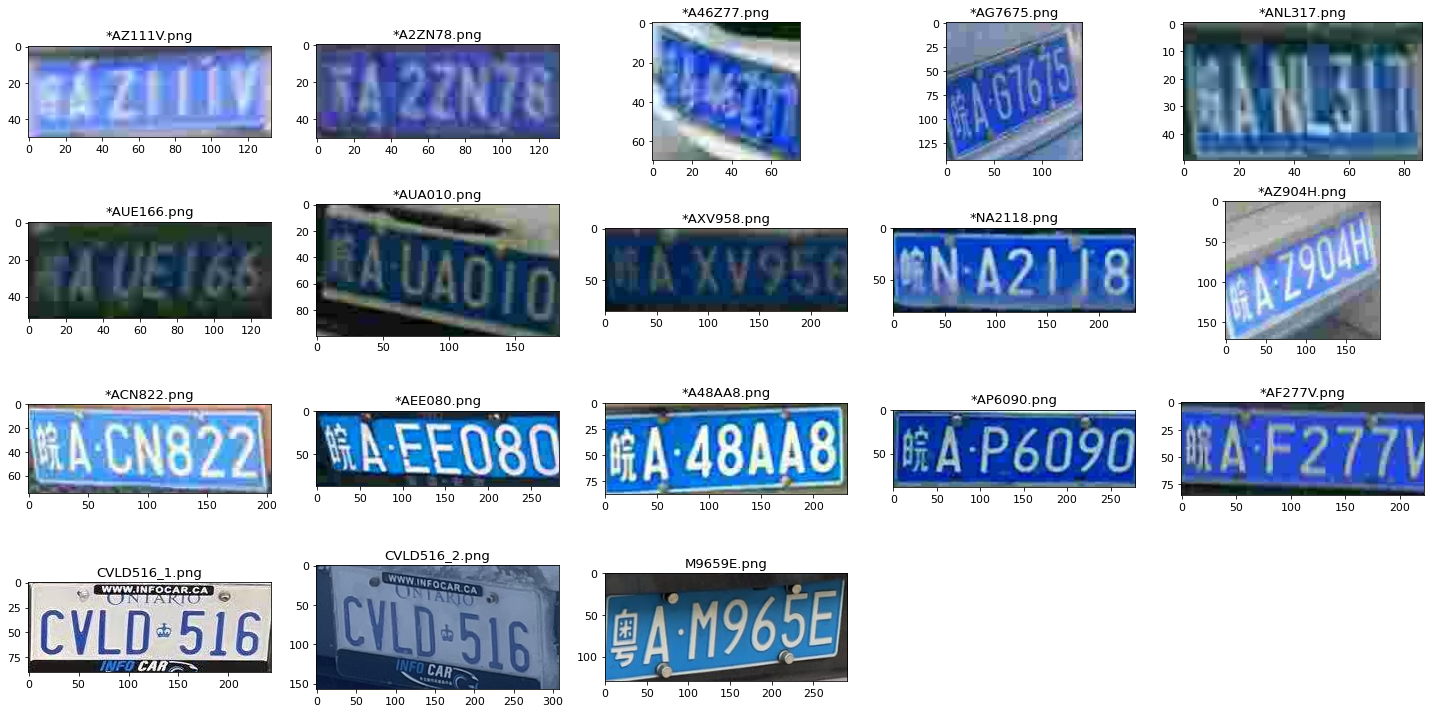

In [ ]:
# plot cropped plate
plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(int(np.ceil(len(number_plate_list)/5)), 5)

for i in range(len(number_plate_list)):
    ax = plt.subplot(gs[i])
    ax.grid(False)
    ax.imshow(number_plate_list[i])
    
    try:
        plate_code_list = [int(element) for element in crop_df.filepath[i].split('/')[-1].split('-')[-3].split('_')]

        for j, number in enumerate(plate_code_list):
            if j == 0:
                province = '*' # ignore province chinese character
            elif j == 1:
                alphabet = alphabets[number]
            elif j == 2:
                ads1 = ads[number]
            elif j == 3:
                ads2 = ads[number]
            elif j == 4:
                ads3 = ads[number]
            elif j == 5:
                ads4 = ads[number]
            elif j == 6:
                ads5 = ads[number]

        img_name = province+alphabet+ads1+ads2+ads3+ads4+ads5+'.png'
    except:
        img_name = crop_df.filepath[i].split('/')[-1]
    ax.set_title(img_name)
    plt.imsave(cropped_result_root+'/'+img_name, number_plate_list[i])
plt.tight_layout()
plt.show()

### 5.3 Save rotated cropped car plate

In [ ]:
correct_result_root = 'correct_result'
cropped_result_root = 'cropped_result'

In [ ]:
if os.path.exists(correct_result_root): # remove folder (also content inside) if exist
    shutil.rmtree(correct_result_root)
os.makedirs(correct_result_root) # recreate data folder

In [ ]:
def cropped_correction(file, img, idx):
    img_cpy1 = img.copy()
    img_cpy1_rgb = cv2.cvtColor(img_cpy1, cv2.COLOR_BGR2RGB)
    img_cpy2 = img.copy()
    img_cpy2_rgb = cv2.cvtColor(img_cpy2, cv2.COLOR_BGR2RGB)

    # ori
    ax = plt.subplot(gs[idx, 0])
    plt.title(file)
    plt.imshow(img_cpy1_rgb)
    (height, width) = img.shape[:2]

    # gray
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ax = plt.subplot(gs[idx, 1])
    plt.title('gray')
    ax.imshow(gray_img, cmap='gray')

    # gaussian filter
    img_gau = cv2.GaussianBlur(gray_img, (5, 5), 1)
    ax = plt.subplot(gs[idx, 2])
    plt.title('img_gau')
    ax.imshow(img_gau, cmap='gray')

    # binary filter
    binary = cv2.adaptiveThreshold(img_gau, 100, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 51, 5)
    ax = plt.subplot(gs[idx, 3])
    plt.title('binary')
    ax.imshow(binary, cmap='gray')

    # canny detect edge
    canny = cv2.Canny(binary, 0, 255)
    ax = plt.subplot(gs[idx, 4])
    plt.title('canny')
    ax.imshow(canny, cmap='gray')
    
    # dilation
    kernel_dilated = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    dilated = cv2.dilate(canny, kernel_dilated, iterations=1)
    ax = plt.subplot(gs[idx, 5])
    plt.title('dilated')
    ax.imshow(dilated, cmap='gray')

    # erosion
    kernel_erode = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4, 4))
    erode = cv2.erode(dilated, kernel_erode, iterations=1)
    ax = plt.subplot(gs[idx, 6])
    plt.title('erode')
    ax.imshow(erode, cmap='gray')

    # find contour
    contours, hierarchy = cv2.findContours(erode, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    area = 0
    index = 0
    for i in range(len(contours)):
        x, y, w, h = cv2.boundingRect(contours[i])
        # w < 100 and h < 35 are not car plate
        if w < 100 and h < 35:
            continue
        # since cropped img is carplate, so only part of carplate is selected if contour are too small
        if h < 0.8 * height or w < 0.8 * width:
            continue
        tmpArea = w * h
        if tmpArea >= area: # find max area of contour
            area = tmpArea
            index = i
 
    # get the min area rectangle for that contour with max area https://theailearner.com/tag/cv2-minarearect/
    rect = cv2.minAreaRect(contours[index])
    # draw that min area rect
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    cv2.drawContours(img_cpy1_rgb, [box], 0, (0, 0, 255), 2)
    img_diag_dist = np.sqrt((img.shape[0])**2 + (img.shape[1])**2)
    ax = plt.subplot(gs[idx, 7])
    plt.title('min_rect')
    ax.imshow(img_cpy1_rgb)

    # get angle of min area rect
    angle = rect[-1]

    # set rotation angle for rotation matrix
    if angle > 85: # not rotate for >85
        angle = 0
    elif angle < 45:
        angle = angle # rotate by min area rect degree
    else:
        angle = angle - 90 # if [45, 85], minus 90. eg. 69 degree to -21 degree

    # for checking the min area rect size
    box_xmin = box[2][0]
    box_ymin = box[2][1]
    box_xmax = box[0][0]
    box_ymax = box[0][1]
    dist = np.sqrt((box_xmax - box_xmin)**2 + (box_ymax - box_ymin)**2)

    # rotate min area rect
    M = cv2.getRotationMatrix2D(rect[0], angle, 1)
    if dist < img_diag_dist*0.8:
        rotated = img_cpy2_rgb # if min_rect is not correct, not rotate
    else:
        rotated = cv2.warpAffine(img_cpy2_rgb, M, (width, height), flags=cv2.INTER_CUBIC, borderValue=(255, 255, 255))

    # rotated
    ax = plt.subplot(gs[idx, 8])
    plt.title('rotated')
    ax.imshow(rotated)
    return rotated

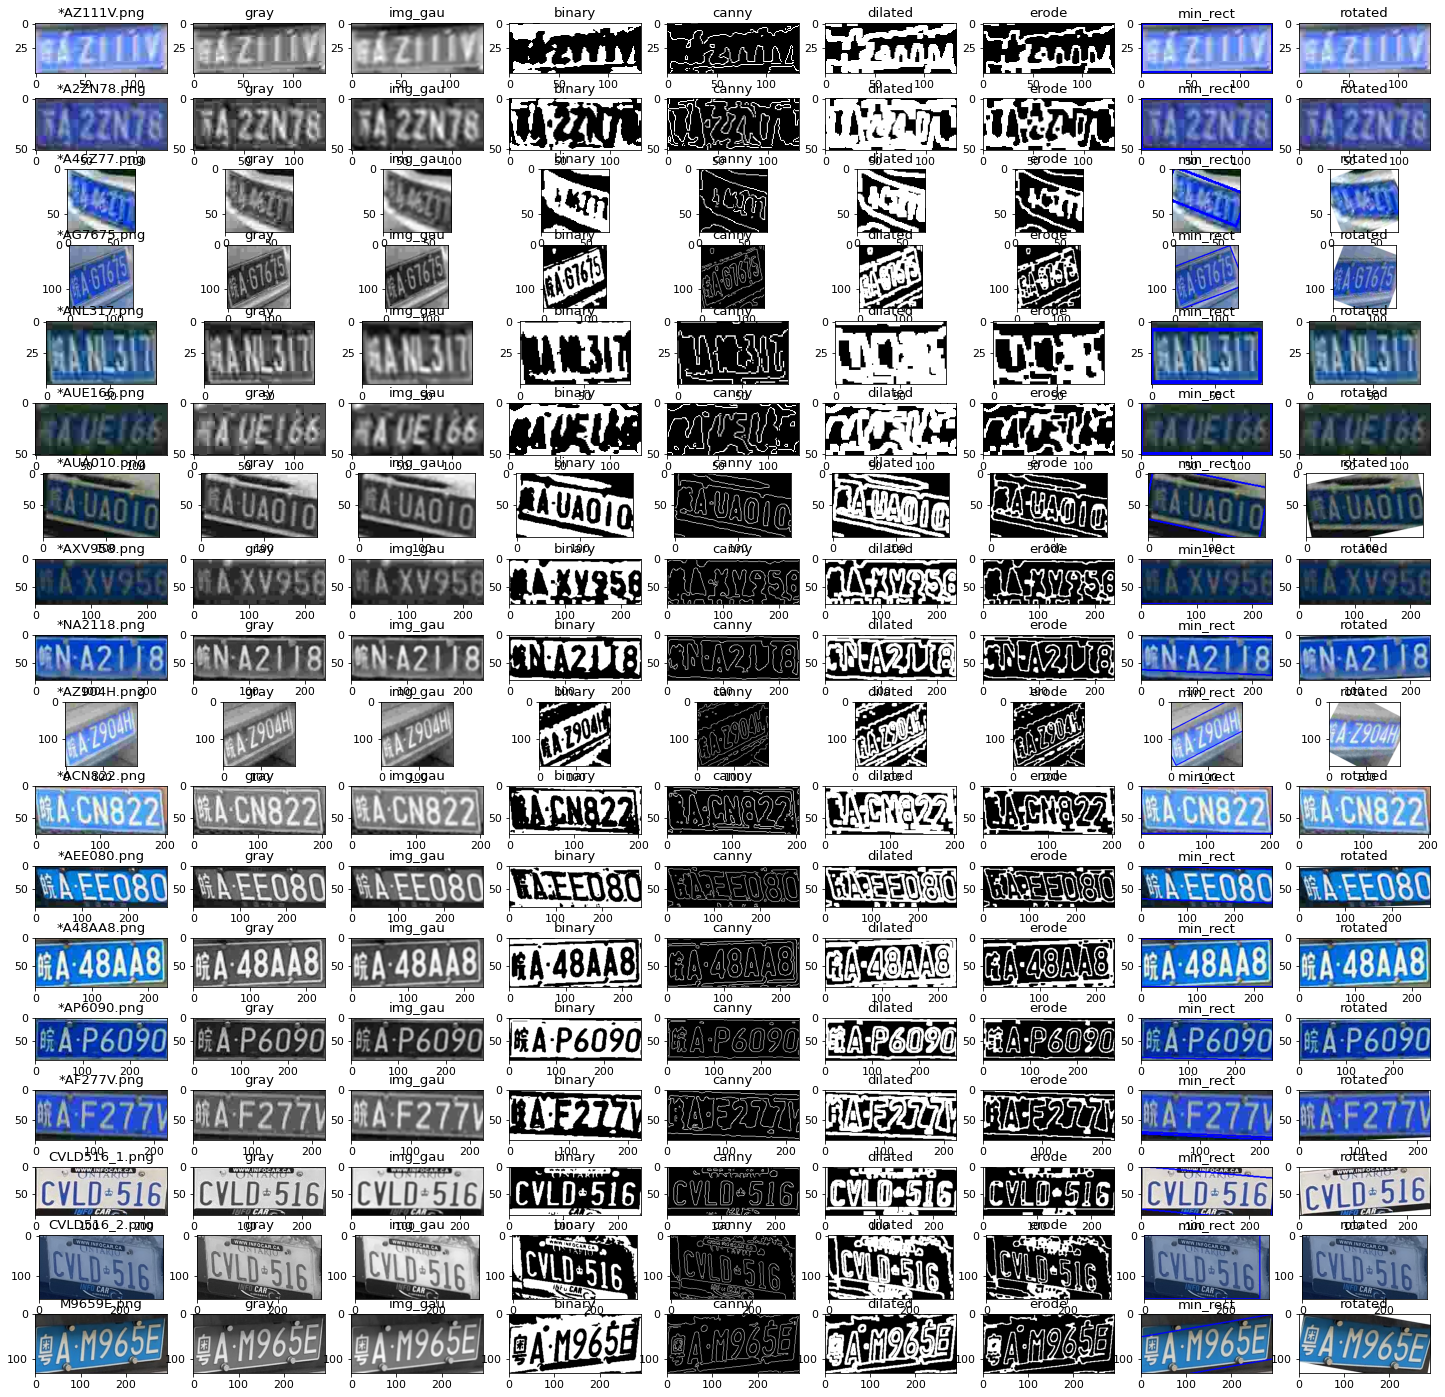

In [ ]:
gs = gridspec.GridSpec(18, 9)
plt.figure(figsize=(25, 25))
for roots, dirs, files in os.walk(cropped_result_root): # walk through level by level
    if len(dirs) == 0:
        idx = 0
        for idx, file in enumerate(files):
            img_src = cv2.imread('cropped_result/'+file)
            rotated = cropped_correction(file, img_src, idx)
            plt.imsave(correct_result_root+'/'+file, rotated)
plt.show()

## 7 Recognition

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 22 not upgraded.
Need to get 4,850 kB of archives.
After this operation, 16.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1 [1,598 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr amd64 4.1.1-2build2 [262 kB]
Fetched 4,850 kB in 0s (31.2 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/Fron

In [ ]:
import pytesseract
import shutil
import os
import random
from PIL import Image

In [ ]:
! wget https://raw.githubusercontent.com/tesseract-ocr/tessdata_best/master/eng.traineddata
! sudo mv "eng.traineddata" "/usr/share/tesseract-ocr/4.00/tessdata"

--2023-03-12 20:02:55--  https://raw.githubusercontent.com/tesseract-ocr/tessdata_best/master/eng.traineddata
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15400601 (15M) [application/octet-stream]
Saving to: ‘eng.traineddata’

eng.traineddata     100%[===================>]  14.69M  76.6MB/s    in 0.2s    

2023-03-12 20:02:57 (76.6 MB/s) - ‘eng.traineddata’ saved [15400601/15400601]



*AZ111V.png


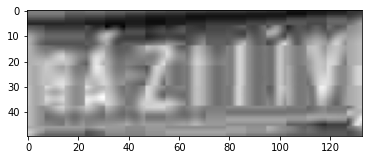

Z111V

----------
*AG7675.png


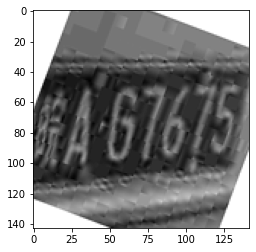

A
LE

----------
*A46Z77.png


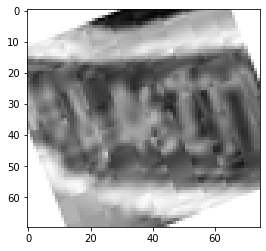

TE
LI

----------
*A2ZN78.png


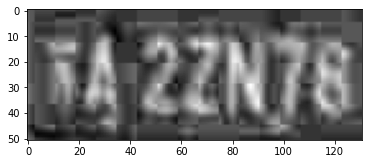

HRI

----------
*AUE166.png


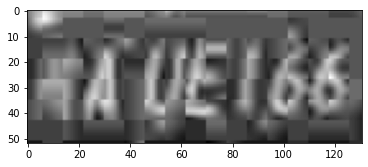

FNL

----------
*ANL317.png


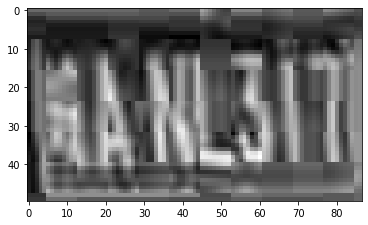

RANI

----------
*ACN822.png


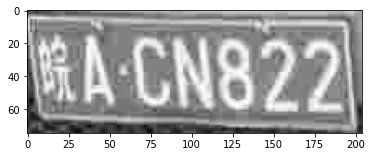

KACNB22

----------
*AZ904H.png


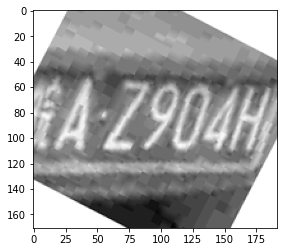

LR
RK

----------
*NA2118.png


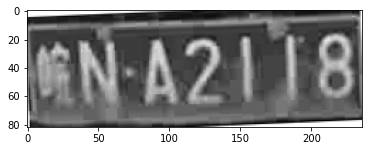

MIVA

----------
*AXV958.png


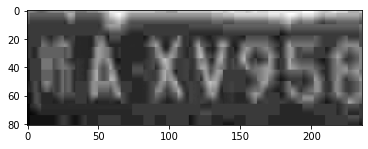

STL

----------
*AUA010.png


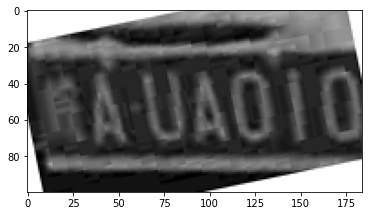

WLLL

----------
*AEE080.png


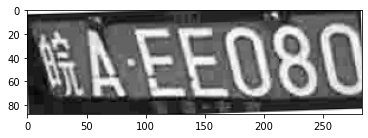

ETS

----------
*A48AA8.png


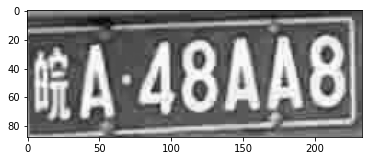

IY

----------
*AF277V.png


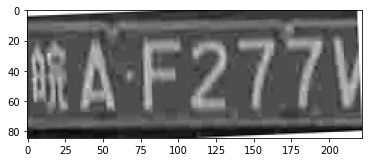


----------
CVLD516_1.png


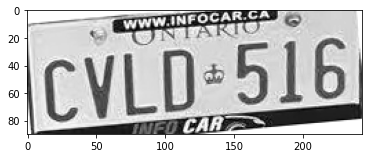

CVID516

----------
*AP6090.png


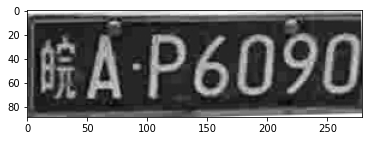

YAEL

----------
CVLD516_2.png


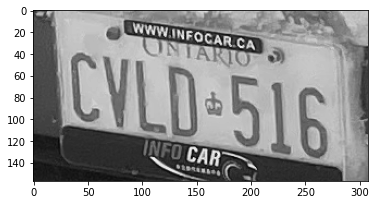


----------
M9659E.png


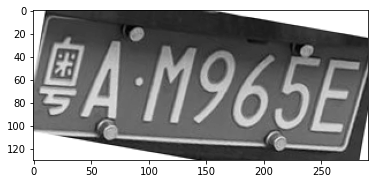

94119656

----------


In [ ]:
plate_recognition_data_path = 'correct_result'

for root, dirs, file_names in os.walk(plate_recognition_data_path):
    for file_name in file_names:

        print(file_name)
        img = cv2.imread(plate_recognition_data_path + '/' + file_name)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        plt.imshow(gray, cmap='gray')
        plt.show()
        text = pytesseract.image_to_string(gray, config='-c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ --psm 6 --oem 3')
        print(text)
        print('----------')

# Summary of Related Work

- “Automatic Number Plate Recognition” by Ahmedov Aslan

In this article, the author introduces the use of deep learning for automatic number plate recognition using object detection techniques. Similar to what we did, the system has 2 main components: license plate detection and character recognition. 

For license plate detection, the author first introduces the usage of Inception-Resnet-V2 for object detection, and then uses YOLO for real time number plate recognition. The author then discusses how the detected license plate can be cropped and preprocessed to improve the accuracy of the character recognition stage.

As for the character recognition, the author suggests using Optical Character Recognition(OCR) software from Tesseract  to extract text from the image. However, such approaches have limitations that it only works well with clean segmentation of foreground text from the background. Size, contrast and lighting are all critical factors that could affect the performance of character recognition. 

Overall, the article provides a concise introduction to the use of deep learning for Automatic Number Plate Recognition, specifically focusing on object detection and character recognition techniques. Unlike our project, this article has most of the dataset with multiple car plates which are far away from the camera, whereas most of our dataset images are single car plate pictures that are close to the camera. In a sense of public usage, their model is definitely more efficient and useful for traffic enforcement.

Ahmedov Aslan, “Automatic Number Plate Recognition”, 2022. [Online] https://www.kaggle.com/code/aslanahmedov/automatic-number-plate-recognition#4.-DEEP-LE ARNING-FOR-OBJECT-DETECTION-

- “License Plate Detection and Recognition in Unconstrained Scenarios” by S´ergio Montazzolli Silva and Cl´audio Rosito Jung

While the majority of existing Automatic License Plate Recognition methods focus on specific license plate regions and frontal images, this study presents a novel Convolutional Neural Network (CNN) capable of detecting and rectifying multiple distorted license plates in a single image, and is applicable to unconstrained capture scenarios. Similarly, the completed Automatic License Plate Recognition system is based on a series of modified YOLO networks, one network to jointly detect cars and LPs, and another network  to perform OCR. This article introduces 3 main steps: Vehicle detection, license plate detection and then character recognition. 

For the Vehicle detection, they decided to use the YOLOv2 network to perform detection, with an execution speed around 70 FPS and 76.8% mAP over their dataset. The positive detections are then resized before being fed to WPOD-NET to reduce computational cost while still maintaining a relatively high accuracy. 

For the license plate detection and unwarping, they proposed a novel CNN called Warped Planar Object Detection Network. The neural network is trained to detect license plates in various distortions and does a transformation that rectifies the distorted license plate to a rectangular shape similar to a frontal view. As for the character recognition, the Optical Character Recognition(OCR) is used here as well. 

S. M. Silva and C. R. Jung, "License Plate Detection and Recognition in Unconstrained Scenarios," 2018 European Conference on Computer Vision (ECCV), Munich, Germany, 2018, pp. 580-596, doi: 10.1007/978-3-030-01264-9_35.

https://openaccess.thecvf.com/content_ECCV_2018/papers/Sergio_Silva_License_Plate_Detection_ECCV_2018_paper.pdf



# Discussion

Our goal was to detect license plates within 20ms, and the final results showed that detection could be completed in 16.1 milliseconds per image, meeting the requirement. Additionally, at epoch 300, our model achieved good numbers in terms of mAP@0.5, precision, and recall, reaching almost 1. The loss plot of training and validation also showed low values around 1.5% and 0.02% respectively at the last epoch, indicating good performance.

During the project, we faced several challenges. For the recognition part, detecting the bounding box of the license plate was challenging due to skewed license plate images. We overcame this by generating multiple rectangles and finding the one with the minimum area, taking into account the rotation angle to account for skewed plates.

Another challenge was the limited performance of pytesseract, which requires high-quality and clean images. However, most of the car license plates in our case were blurred, calibrated by affine transform, and had complex blue backgrounds, resulting in poor performance for image-to-text conversion. Due to time and computational constraints, we did not train our own model for comparison. Overall, these challenges were addressed, and our model achieved good performance within the given constraints.

In [2]:
%%shell
jupyter nbconvert plate_detection_recognition.ipynb --to html

[NbConvertApp] Converting notebook plate_detection_recognition.ipynb to html
[NbConvertApp] Writing 9146377 bytes to plate_detection_recognition.html
